In [1]:

!pip install tensorflow-gpu==2.0.1
import tensorflow as tf
tf.compat.v1.enable_v2_behavior()
print(tf.__version__)

2.0.1


# New Section

In [2]:
!pip install --quiet neural-structured-learning
!pip install --quiet tensorflow-hub

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import matplotlib.pyplot as plt
import numpy as np

import neural_structured_learning as nsl


import tensorflow_hub as hub

# Resets notebook state
tf.keras.backend.clear_session()

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Version:  2.0.1
Eager mode:  True
Hub version:  0.8.0
GPU is available


In [5]:
!wget https://s3.amazonaws.com/fast-ai-nlp/yelp_review_polarity_csv.tgz

--2020-07-08 17:11:29--  https://s3.amazonaws.com/fast-ai-nlp/yelp_review_polarity_csv.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.101.165
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.101.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 166373201 (159M) [application/x-tar]
Saving to: ‘yelp_review_polarity_csv.tgz.1’

yelp_review_polarit 100%[===================>] 158.67M  12.5MB/s    in 14s     

2020-07-08 17:11:44 (11.6 MB/s) - ‘yelp_review_polarity_csv.tgz.1’ saved [166373201/166373201]



In [6]:
!tar -xvzf yelp_review_polarity_csv.tgz

yelp_review_polarity_csv/
yelp_review_polarity_csv/train.csv
yelp_review_polarity_csv/readme.txt
yelp_review_polarity_csv/test.csv


In [7]:
from fastai import * 
from fastai.text import * 
from fastai.core import *

In [8]:
path = Path('yelp_review_polarity_csv')
train_csv = path/'train.csv'
train = pd.read_csv(train_csv, header=None) 
test_csv = path/'test.csv'
test= pd.read_csv(test_csv, header=None) 
train.head()

,0,1
0,1,"Unfortunately, the frustration of being Dr. Go..."
1,2,Been going to Dr. Goldberg for over 10 years. ...
2,1,I don't know what Dr. Goldberg was like before...
3,1,I'm writing this review to give you a heads up...
4,2,All the food is great here. But the best thing...


In [9]:
test.head()

,0,1
0,2,"Contrary to other reviews, I have zero complai..."
1,1,Last summer I had an appointment to get new ti...
2,2,"Friendly staff, same starbucks fair you get an..."
3,1,The food is good. Unfortunately the service is...
4,2,Even when we didn't have a car Filene's Baseme...


In [10]:
import csv

import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
from itertools import islice
articles = []
labels = []

with open(train_csv, 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in islice(reader,0,25000):
        labels.append(row[0])
        article = row[1]
        for word in STOPWORDS:
            token = ' ' + word + ' '
            article = article.replace(token, ' ')
            article = article.replace(' ', ' ')
        articles.append(article)
print(len(labels))
print(len(articles))

25000
25000


In [12]:
labels = [int(i) for i in labels]
labels = [0 if i==1 else 1 for i in labels]

pp_train_data = articles
pp_train_labels = labels

pp_test_data = []
pp_test_labels = []

with open(test_csv, 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in islice(reader,0,25000):
        pp_test_labels.append(row[0])
        article = row[1]
        for word in STOPWORDS:
            token = ' ' + word + ' '
            article = article.replace(token, ' ')
            article = article.replace(' ', ' ')
        pp_test_data.append(article)
print(len(pp_test_labels))
print(len(pp_test_data))




25000
25000


In [13]:
tokenizer = Tokenizer(num_words = 10000)
tokenizer.fit_on_texts(pp_train_data)
word_index = tokenizer.word_index

In [14]:
pp_train_data = tokenizer.texts_to_sequences(pp_train_data)

In [15]:
print(pp_train_data[10])

[420, 3693, 5153, 3733, 461, 2787, 3831, 7, 175, 196, 241, 183, 181, 4374]


In [16]:
pp_test_data  = tokenizer.texts_to_sequences(pp_test_data)
print(pp_test_data[0])

[103, 985, 1, 551, 9, 88, 1539, 93, 309, 130, 11, 1, 28, 37, 258, 749, 3224, 346, 1172, 187, 170, 20, 1135, 219, 124, 485, 1, 636, 1, 161, 1173, 192, 21, 2304, 65, 3125, 25, 44, 16, 20, 431, 665, 193]


In [17]:
pp_test_labels = [int(i) for i in pp_test_labels]
pp_test_labels = [0 if i==1 else 1 for i in pp_test_labels]

In [18]:
def build_reverse_word_index(word_index):
      # The first indices are reserved
      #word_index = {k: (v + 1) for k, v in word_index.items()}
      word_index['<PAD>'] = 0
      #word_index['<UNK>'] = 2  # unknown
      return dict((value, key) for (key, value) in word_index.items())

reverse_word_index = build_reverse_word_index(word_index)

def decode_review(text):
  return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [19]:
decode_review(pp_train_data[10])


"wonderful reuben map shown yelp page incorrect it actually different i'd recommend call directions"

Graph construction
Graph construction involves creating embeddings for text samples and then using a similarity function to compare the embeddings.

Before proceeding further, we first create a directory to store artifacts created by this tutorial.

In [20]:
!mkdir -p /tmp/yelp

Create sample embeddings

In [21]:
# This is necessary because hub.KerasLayer assumes tensor hashability, which
# is not supported in eager mode.
tf.compat.v1.disable_tensor_equality()

pretrained_embedding = 'https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1'

hub_layer = hub.KerasLayer(
    pretrained_embedding, input_shape=[], dtype=tf.string, trainable=True)

In [22]:
def _int64_feature(value):
  """Returns int64 tf.train.Feature."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=value.tolist()))


def _bytes_feature(value):
  """Returns bytes tf.train.Feature."""
  return tf.train.Feature(
      bytes_list=tf.train.BytesList(value=[value.encode('utf-8')]))


def _float_feature(value):
  """Returns float tf.train.Feature."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=value.tolist()))


def create_embedding_example(word_vector, record_id):
  """Create tf.Example containing the sample's embedding and its ID."""

  text = decode_review(word_vector)

  # Shape = [batch_size,].
  sentence_embedding = hub_layer(tf.reshape(text, shape=[-1,]))

  # Flatten the sentence embedding back to 1-D.
  sentence_embedding = tf.reshape(sentence_embedding, shape=[-1])

  features = {
      'id': _bytes_feature(str(record_id)),
      'embedding': _float_feature(sentence_embedding.numpy())
  }
  return tf.train.Example(features=tf.train.Features(feature=features))


def create_embeddings(word_vectors, output_path, starting_record_id):
  record_id = int(starting_record_id)
  with tf.io.TFRecordWriter(output_path) as writer:
    for word_vector in word_vectors:
      example = create_embedding_example(word_vector, record_id)
      record_id = record_id + 1
      writer.write(example.SerializeToString())
  return record_id

# Persist TF.Example features containing embeddings for training data in
# TFRecord format.
create_embeddings(pp_train_data, '/tmp/yelp/embeddings.tfr', 0)

25000

### Build a graph

Now that we have the sample embeddings, we will use them to build a similarity
graph, i.e, nodes in this graph will correspond to samples and edges in this
graph will correspond to similarity between pairs of nodes.

Neural Structured Learning provides a graph building library to build a graph
based on sample embeddings. It uses **cosine similarity** as the similarity
measure to compare embeddings and build edges between them. It also allows us to
specify a similarity threshold, which can be used to discard dissimilar edges
from the final graph. In this example, using 0.99 as the similarity threshold,
we end up with a graph that has 445,327 bi-directional edges.

In [23]:
nsl.tools.build_graph(['/tmp/yelp/embeddings.tfr'],
                      '/tmp/yelp/graph_99.tsv',
                      similarity_threshold=0.99)

## Sample features

We create sample features for our problem using the `tf.train.Example` format
and persist them in the `TFRecord` format. Each sample will include the
following three features:

1.  **id**: The node ID of the sample.
2.  **words**: An int64 list containing word IDs.
3.  **label**: A singleton int64 identifying the target class of the review.

In [24]:
def create_example(word_vector, label, record_id):
  """Create tf.Example containing the sample's word vector, label, and ID."""
  features = {
      'id': _bytes_feature(str(record_id)),
      'words': _int64_feature(np.asarray(word_vector)),
      'label': _int64_feature(np.asarray([label])),
  }
  return tf.train.Example(features=tf.train.Features(feature=features))

def create_records(word_vectors, labels, record_path, starting_record_id):
  record_id = int(starting_record_id)
  with tf.io.TFRecordWriter(record_path) as writer:
    for word_vector, label in zip(word_vectors, labels):
      example = create_example(word_vector, label, record_id)
      record_id = record_id + 1
      writer.write(example.SerializeToString())
  return record_id

# Persist TF.Example features (word vectors and labels) for training and test
# data in TFRecord format.
next_record_id = create_records(pp_train_data, pp_train_labels,
                                '/tmp/yelp/train_data.tfr', 0)
create_records(pp_test_data, pp_test_labels, '/tmp/yelp/test_data.tfr',
               next_record_id)

50000

In [25]:
nsl.tools.pack_nbrs(
    '/tmp/yelp/train_data.tfr',
    '',
    '/tmp/yelp/graph_99.tsv',
    '/tmp/yelp/nsl_train_data.tfr',
    add_undirected_edges=True,
    max_nbrs=3)

## Base model

We are now ready to build a base model without graph regularization. In order to
build this model, we can either use embeddings that were used in building the
graph, or we can learn new embeddings jointly along with the classification
task. For the purpose of this notebook, we will do the latter.

### Global variables

In [26]:
NBR_FEATURE_PREFIX = 'NL_nbr_'
NBR_WEIGHT_SUFFIX = '_weight'

### Hyperparameters

We will use an instance of `HParams` to inclue various hyperparameters and
constants used for training and evaluation. We briefly describe each of them
below:

-   **num_classes**: There are 2 classes -- *positive* and *negative*.

-   **max_seq_length**: This is the maximum number of words considered from each
    movie review in this example.

-   **vocab_size**: This is the size of the vocabulary considered for this
    example.

-   **distance_type**: This is the distance metric used to regularize the sample
    with its neighbors.

-   **graph_regularization_multiplier**: This controls the relative weight of
    the graph regularization term in the overall loss function.

-   **num_neighbors**: The number of neighbors used for graph regularization.
    This value has to be less than or equal to the `max_nbrs` argument used
    above when invoking `nsl.tools.pack_nbrs`.

-   **num_fc_units**: The number of units in the fully connected layer of the
    neural network.

-   **train_epochs**: The number of training epochs.

-   **batch_size**: Batch size used for training and evaluation.

-   **eval_steps**: The number of batches to process before deeming evaluation
    is complete. If set to `None`, all instances in the test set are evaluated.

In [46]:
class HParams(object):
  """Hyperparameters used for training."""
  def __init__(self):
    ### dataset parameters
    self.num_classes = 2
    self.max_seq_length = 256
    self.vocab_size = 10000
    ### neural graph learning parameters
    self.distance_type = nsl.configs.DistanceType.L2
    self.graph_regularization_multiplier = 0.1
    self.num_neighbors = 2
    ### model architecture
    self.num_embedding_dims = 16
    self.num_lstm_dims = 64
    self.num_fc_units = 64
    ### training parameters
    self.train_epochs = 20
    self.batch_size = 128
    ### eval parameters
    self.eval_steps = None  # All instances in the test set are evaluated.

HPARAMS = HParams()

### Prepare the data

The reviews—the arrays of integers—must be converted to tensors before being fed
into the neural network. This conversion can be done a couple of ways:

*   Convert the arrays into vectors of `0`s and `1`s indicating word occurrence,
    similar to a one-hot encoding. For example, the sequence `[3, 5]` would         become a `10000`-dimensional vector that is all zeros except for indices        `3` and `5`, which are ones. Then, make this the first layer in our             network—a `Dense` layer—that can handle floating point vector data. This        approach is memory intensive, though, requiring a `num_words * num_reviews`     size matrix.

*   Alternatively, we can pad the arrays so they all have the same length, then
    create an integer tensor of shape `max_length * num_reviews`. We can use an
    embedding layer capable of handling this shape as the first layer in our
    network.

In this tutorial, we will use the second approach.

Since the movie reviews must be the same length, we will use the `pad_sequence`
function defined below to standardize the lengths.

In [28]:
def pad_sequence(sequence, max_seq_length):
  """Pads the input sequence (a `tf.SparseTensor`) to `max_seq_length`."""
  pad_size = tf.maximum([0], max_seq_length - tf.shape(sequence)[0])
  padded = tf.concat(
      [sequence.values,
       tf.fill((pad_size), tf.cast(0, sequence.dtype))],
      axis=0)
  # The input sequence may be larger than max_seq_length. Truncate down if
  # necessary.
  return tf.slice(padded, [0], [max_seq_length])

def parse_example(example_proto):
  """Extracts relevant fields from the `example_proto`.

  Args:
    example_proto: An instance of `tf.train.Example`.

  Returns:
    A pair whose first value is a dictionary containing relevant features
    and whose second value contains the ground truth labels.
  """
  # The 'words' feature is a variable length word ID vector.
  feature_spec = {
      'words': tf.io.VarLenFeature(tf.int64),
      'label': tf.io.FixedLenFeature((), tf.int64, default_value=-1),
  }
  # We also extract corresponding neighbor features in a similar manner to
  # the features above.
  for i in range(HPARAMS.num_neighbors):
    nbr_feature_key = '{}{}_{}'.format(NBR_FEATURE_PREFIX, i, 'words')
    nbr_weight_key = '{}{}{}'.format(NBR_FEATURE_PREFIX, i, NBR_WEIGHT_SUFFIX)
    feature_spec[nbr_feature_key] = tf.io.VarLenFeature(tf.int64)

    # We assign a default value of 0.0 for the neighbor weight so that
    # graph regularization is done on samples based on their exact number
    # of neighbors. In other words, non-existent neighbors are discounted.
    feature_spec[nbr_weight_key] = tf.io.FixedLenFeature(
        [1], tf.float32, default_value=tf.constant([0.0]))

  features = tf.io.parse_single_example(example_proto, feature_spec)

  # Since the 'words' feature is a variable length word vector, we pad it to a
  # constant maximum length based on HPARAMS.max_seq_length
  features['words'] = pad_sequence(features['words'], HPARAMS.max_seq_length)
  for i in range(HPARAMS.num_neighbors):
    nbr_feature_key = '{}{}_{}'.format(NBR_FEATURE_PREFIX, i, 'words')
    features[nbr_feature_key] = pad_sequence(features[nbr_feature_key],
                                             HPARAMS.max_seq_length)

  labels = features.pop('label')
  return features, labels

def make_dataset(file_path, training=False):
  """Creates a `tf.data.TFRecordDataset`.

  Args:
    file_path: Name of the file in the `.tfrecord` format containing
      `tf.train.Example` objects.
    training: Boolean indicating if we are in training mode.

  Returns:
    An instance of `tf.data.TFRecordDataset` containing the `tf.train.Example`
    objects.
  """
  dataset = tf.data.TFRecordDataset([file_path])
  if training:
    dataset = dataset.shuffle(10000)
  dataset = dataset.map(parse_example)
  dataset = dataset.batch(HPARAMS.batch_size)
  return dataset

train_dataset = make_dataset('/tmp/yelp/nsl_train_data.tfr', True)
test_dataset = make_dataset('/tmp/yelp/test_data.tfr')

### Build the model

A neural network is created by stacking layers—this requires two main architectural decisions:

* How many layers to use in the model?
* How many *hidden units* to use for each layer?

In this example, the input data consists of an array of word-indices. The labels to predict are either 0 or 1.

We will use a bi-directional LSTM as our base model in this tutorial.

In [29]:
# This function exists as an alternative to the bi-LSTM model used in this
# notebook.
def make_feed_forward_model():
  """Builds a simple 2 layer feed forward neural network."""
  inputs = tf.keras.Input(
      shape=(HPARAMS.max_seq_length,), dtype='int64', name='words')
  embedding_layer = tf.keras.layers.Embedding(HPARAMS.vocab_size, 16)(inputs)
  pooling_layer = tf.keras.layers.GlobalAveragePooling1D()(embedding_layer)
  dense_layer = tf.keras.layers.Dense(16, activation='relu')(pooling_layer)
  outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense_layer)
  return tf.keras.Model(inputs=inputs, outputs=outputs)


def make_bilstm_model():
  """Builds a bi-directional LSTM model."""
  inputs = tf.keras.Input(
      shape=(HPARAMS.max_seq_length,), dtype='int64', name='words')
  embedding_layer = tf.keras.layers.Embedding(HPARAMS.vocab_size,
                                              HPARAMS.num_embedding_dims)(
                                                  inputs)
  lstm_layer = tf.keras.layers.Bidirectional(
      tf.keras.layers.LSTM(HPARAMS.num_lstm_dims))(
          embedding_layer)
  dense_layer = tf.keras.layers.Dense(
      HPARAMS.num_fc_units, activation='relu')(
          lstm_layer)
  outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense_layer)
  return tf.keras.Model(inputs=inputs, outputs=outputs)


# Feel free to use an architecture of your choice.
model = make_bilstm_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
words (InputLayer)           [(None, 256)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 256, 16)           160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               41472     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 209,793
Trainable params: 209,793
Non-trainable params: 0
_________________________________________________________________


The layers are effectively stacked sequentially to build the classifier:

1.  The first layer is an `Input` layer which takes the integer-encoded
    vocabulary.
2.  The next layer is an `Embedding` layer, which takes the integer-encoded
    vocabulary and looks up the embedding vector for each word-index. These
    vectors are learned as the model trains. The vectors add a dimension to the
    output array. The resulting dimensions are: `(batch, sequence, embedding)`.
3.  Next, a bidirectional LSTM layer returns a fixed-length output vector for
    each example.
4.  This fixed-length output vector is piped through a fully-connected (`Dense`)
    layer with 64 hidden units.
5.  The last layer is densely connected with a single output node. Using the
    `sigmoid` activation function, this value is a float between 0 and 1,
    representing a probability, or confidence level.

### Hidden units

The above model has two intermediate or "hidden" layers, between the input and
output, and excluding the `Embedding` layer. The number of outputs (units,
nodes, or neurons) is the dimension of the representational space for the layer.
In other words, the amount of freedom the network is allowed when learning an
internal representation.

If a model has more hidden units (a higher-dimensional representation space),
and/or more layers, then the network can learn more complex representations.
However, it makes the network more computationally expensive and may lead to
learning unwanted patterns—patterns that improve performance on training data
but not on the test data. This is called *overfitting*.

### Loss function and optimizer

A model needs a loss function and an optimizer for training. Since this is a
binary classification problem and the model outputs a probability (a single-unit
layer with a sigmoid activation), we'll use the `binary_crossentropy` loss
function.

In [30]:
model.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Create a validation set

When training, we want to check the accuracy of the model on data it hasn't seen
before. Create a *validation set* by setting apart a fraction of the original
training data. (Why not use the testing set now? Our goal is to develop and tune
our model using only the training data, then use the test data just once to
evaluate our accuracy).

In this tutorial, we take roughly 10% of the initial training samples (10% of 25000) as labeled data for training and the remaining as validation data. Since the initial train/test split was 50/50 (25000 samples each), the effective train/validation/test split we now have is 5/45/50.

Note that 'train_dataset' has already been batched and shuffled. 

In [31]:
training_samples_count = len(pp_train_data)
validation_fraction = 0.4
validation_size = int(validation_fraction *
                      int(training_samples_count / HPARAMS.batch_size))
print(validation_size)
validation_dataset = train_dataset.take(validation_size)
train_dataset = train_dataset.skip(validation_size)

78


### Train the model

Train the model in mini-batches. While training, monitor the model's loss and accuracy on the validation set:

In [32]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=HPARAMS.train_epochs,
    verbose=1)

Epoch 1/20
118/118 [==============================] - 17s 141ms/step - loss: 0.4978 - accuracy: 0.7390 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
118/118 [==============================] - 7s 57ms/step - loss: 0.2240 - accuracy: 0.9140 - val_loss: 0.2043 - val_accuracy: 0.9211
Epoch 3/20
118/118 [==============================] - 7s 56ms/step - loss: 0.1773 - accuracy: 0.9367 - val_loss: 0.1757 - val_accuracy: 0.9360
Epoch 4/20
118/118 [==============================] - 6s 54ms/step - loss: 0.1356 - accuracy: 0.9511 - val_loss: 0.1631 - val_accuracy: 0.9423
Epoch 5/20
118/118 [==============================] - 7s 57ms/step - loss: 0.1218 - accuracy: 0.9583 - val_loss: 0.1372 - val_accuracy: 0.9526
Epoch 6/20
118/118 [==============================] - 6s 53ms/step - loss: 0.0987 - accuracy: 0.9678 - val_loss: 0.1559 - val_accuracy: 0.9444
Epoch 7/20
118/118 [==============================] - 6s 53ms/step - loss: 0.0899 - accuracy: 0.9710 - val_loss: 0.1146 - val_accura

### Evaluate the model

Now, let's see how the model performs. Two values will be returned. Loss (a number which represents our error, lower values are better), and accuracy.

In [33]:
results = model.evaluate(test_dataset, steps=HPARAMS.eval_steps)
print(results)

196/196 [==============================] - 4s 20ms/step - loss: 1.3902 - accuracy: 0.8344
[1.3902316394509102, 0.8344]


### Create a graph of accuracy/loss over time

`model.fit()` returns a `History` object that contains a dictionary with everything that happened during training:

In [34]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

There are four entries: one for each monitored metric during training and validation. We can use these to plot the training and validation loss for comparison, as well as the training and validation accuracy:

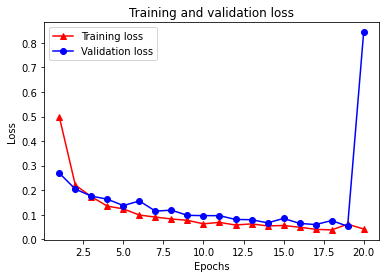

In [35]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "-r^" is for solid red line with triangle markers.
plt.plot(epochs, loss, '-r^', label='Training loss')
# "-b0" is for solid blue line with circle markers.
plt.plot(epochs, val_loss, '-bo', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')

plt.show()

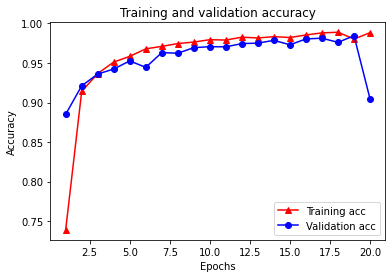

In [36]:
plt.clf()   # clear figure

plt.plot(epochs, acc, '-r^', label='Training acc')
plt.plot(epochs, val_acc, '-bo', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')

plt.show()

Notice the training loss *decreases* with each epoch and the training accuracy
*increases* with each epoch. This is expected when using a gradient descent
optimization—it should minimize the desired quantity on every iteration.

## Graph regularization

We are now ready to try graph regularization using the base model that we built
above. We will use the `GraphRegularization` wrapper class provided by the
Neural Structured Learning framework to wrap the base (bi-LSTM) model to include
graph regularization. The rest of the steps for training and evaluating the
graph-regularized model are similar to that of the base model.

### Create graph-regularized model

To assess the incremental benefit of graph regularization, we will create a new
base model instance. This is because `model` has already been trained for a few
iterations, and reusing this trained model to create a graph-regularized model
will not be a fair comparison for `model`.

In [37]:
# Build a new base LSTM model.
base_reg_model = make_bilstm_model()

In [38]:
# Wrap the base model with graph regularization.
graph_reg_config = nsl.configs.make_graph_reg_config(
    max_neighbors=HPARAMS.num_neighbors,
    multiplier=HPARAMS.graph_regularization_multiplier,
    distance_type=HPARAMS.distance_type,
    sum_over_axis=-1)
graph_reg_model = nsl.keras.GraphRegularization(base_reg_model,
                                                graph_reg_config)
graph_reg_model.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Train the model

In [39]:
graph_reg_history = graph_reg_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=HPARAMS.train_epochs,
    verbose=1)

Epoch 1/20


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


118/118 [==============================] - 18s 155ms/step - loss: 0.5639 - accuracy: 0.7057 - graph_loss: 0.0460 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_graph_loss: 0.0000e+00
Epoch 2/20
118/118 [==============================] - 11s 96ms/step - loss: 0.2666 - accuracy: 0.9053 - graph_loss: 0.2062 - val_loss: 0.2703 - val_accuracy: 0.8996 - val_graph_loss: 0.2135
Epoch 3/20
118/118 [==============================] - 12s 98ms/step - loss: 0.2111 - accuracy: 0.9327 - graph_loss: 0.2418 - val_loss: 0.2129 - val_accuracy: 0.9310 - val_graph_loss: 0.2532
Epoch 4/20
118/118 [==============================] - 11s 95ms/step - loss: 0.1720 - accuracy: 0.9481 - graph_loss: 0.2586 - val_loss: 0.1948 - val_accuracy: 0.9427 - val_graph_loss: 0.2846
Epoch 5/20
118/118 [==============================] - 11s 92ms/step - loss: 0.1584 - accuracy: 0.9559 - graph_loss: 0.2663 - val_loss: 0.1763 - val_accuracy: 0.9521 - val_graph_loss: 0.2776
Epoch 6/20
118/118 [============================

### Evaluate the model

In [40]:
graph_reg_results = graph_reg_model.evaluate(test_dataset, steps=HPARAMS.eval_steps)
print(graph_reg_results)

196/196 [==============================] - 5s 26ms/step - loss: 0.4765 - accuracy: 0.8868
[0.4765081435289918, 0.88676]


### Create a graph of accuracy/loss over time

In [41]:
graph_reg_history_dict = graph_reg_history.history
graph_reg_history_dict.keys()

dict_keys(['loss', 'accuracy', 'graph_loss', 'val_loss', 'val_accuracy', 'val_graph_loss'])

There are six entries: one for each monitored metric -- loss, graph loss, and
accuracy -- during training and validation. We can use these to plot the
training, graph, and validation losses for comparison, as well as the training
and validation accuracy. Note that the graph loss is only computed during
training; so its value will be 0 during validation.

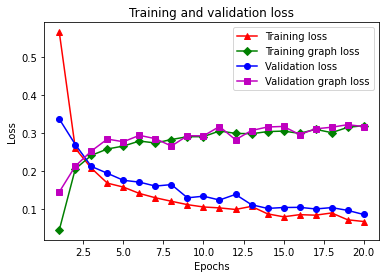

In [42]:
acc = graph_reg_history_dict['accuracy']
val_acc = graph_reg_history_dict['val_accuracy']
loss = graph_reg_history_dict['loss']
graph_loss = graph_reg_history_dict['graph_loss']
val_loss = graph_reg_history_dict['val_loss']
val_graph_loss = graph_reg_history_dict['val_graph_loss']

epochs = range(1, len(acc) + 1)

plt.clf()   # clear figure

# "-r^" is for solid red line with triangle markers.
plt.plot(epochs, loss, '-r^', label='Training loss')
# "-gD" is for solid green line with diamond markers.
plt.plot(epochs, graph_loss, '-gD', label='Training graph loss')
# "-b0" is for solid blue line with circle markers.
plt.plot(epochs, val_loss, '-bo', label='Validation loss')
# "-ms" is for solid magenta line with square markers.
plt.plot(epochs, val_graph_loss, '-ms', label='Validation graph loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')

plt.show()

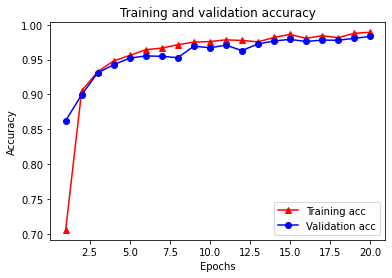

In [43]:
plt.clf()   # clear figure

plt.plot(epochs, acc, '-r^', label='Training acc')
plt.plot(epochs, val_acc, '-bo', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')

plt.show()

## The power of semi-supervised learning (This needs to be updated)


Semi-supervised learning and more specifically, graph regularization in the
context of this tutorial, can be really powerful when the amount of training
data is small. The lack of training data is compensated by leveraging similarity
among the training samples, which is not possible in traditional supervised
learning.

We define ***supervision ratio*** as the ratio of training samples to the total
number of samples which includes training, validation, and test samples. In this
notebook, we have used a supervision ratio of 0.05 (i.e, 5% of the labeled data)
for training both the base model as well as the graph-regularized model. We
illustrate the impact of the supervision ratio on model accuracy in the cell
below.

<Figure size 432x288 with 0 Axes>

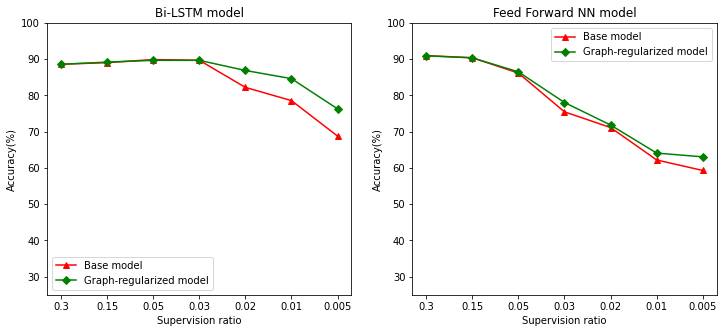

In [44]:
# Accuracy values for both the Bi-LSTM model and the feed forward NN model have
# been precomputed for the following supervision ratios.

#supervision_ratios = [0.3, 0.15, 0.05, 0.03, 0.02, 0.01, 0.005]

#model_tags = ['Bi-LSTM model', 'Feed Forward NN model']
#base_model_accs = [[84, 84, 83, 80, 65, 52, 50], [87, 86, 76, 74, 67, 52, 51]]
#graph_reg_model_accs = [[84, 84, 83, 83, 65, 63, 50],
#                        [87, 86, 80, 75, 67, 52, 50]]

supervision_ratios = [0.3, 0.15, 0.05, 0.03, 0.02, 0.01, 0.005]

model_tags = ['Bi-LSTM model', 'Feed Forward NN model']
base_model_accs = [[88.62, 89.06, 89.91, 89.72, 82.232, 78.584, 68.78],
                        [90.992, 90.42, 86.18, 75.48, 71.15, 62.20, 59.30]]
graph_reg_model_accs = [[88.6, 89.21, 89.7, 89.7, 86.9, 84.64, 76.3], [90.95, 90.38, 86.52, 78.06, 71.84, 64.1, 63.07]]

plt.clf()  # clear figure

fig, axes = plt.subplots(1, 2)
fig.set_size_inches((12, 5))

for ax, model_tag, base_model_acc, graph_reg_model_acc in zip(
    axes, model_tags, base_model_accs, graph_reg_model_accs):

  # "-r^" is for solid red line with triangle markers.
  ax.plot(base_model_acc, '-r^', label='Base model')
  # "-gD" is for solid green line with diamond markers.
  ax.plot(graph_reg_model_acc, '-gD', label='Graph-regularized model')
  ax.set_title(model_tag)
  ax.set_xlabel('Supervision ratio')
  ax.set_ylabel('Accuracy(%)')
  ax.set_ylim((25, 100))
  ax.set_xticks(range(len(supervision_ratios)))
  ax.set_xticklabels(supervision_ratios)
  ax.legend(loc='best')

plt.show()

It can be observed that as the superivision ratio decreases, model accuracy also
decreases. This is true for both the base model and for the graph-regularized
model, regardless of the model architecture used. However, notice that the
graph-regularized model performs better than the base model for both the
architectures. In particular, for the Bi-LSTM model, when the supervision ratio
is 0.01, the accuracy of the graph-regularized model is **~15%** higher than
that of the base model. This is primarily because of semi-supervised learning
for the graph-regularized model, where structural similarity among training
samples is used in addition to the training samples themselves.

## Conclusion

We have demonstrated the use of graph regularization using the Neural Structured
Learning (NSL) framework even when the input does not contain an explicit graph.
We considered the task of sentiment classification of IMDB movie reviews for
which we synthesized a similarity graph based on review embeddings. We encourage
users to experiment further by varying hyperparameters, the amount of
supervision, and by using different model architectures.